In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cbook as cbook
from matplotlib.ticker import FormatStrFormatter
from matplotlib_scalebar.scalebar import ScaleBar
import re
import pandas as pd
%matplotlib inline 
import numpy as np
import math
import pims
import cv2
from scipy import interpolate
from scipy.signal import savgol_filter
import skimage.filters as sk_fil
import imutils
from skimage.transform import rotate
import sys
import PIL
sys.path.insert(0, '/Users/lfsmbn/orkun/projects/ongoing/GBMF_motility/')
import myAnalyses.lowmag_analysis_OSS as dio

DEFINE FILE PATHS

In [2]:


#path = r'/Users/lfsmbn/orkun/projects/ongoing/GBMF_motility/Data/04-08-2022/Partitioned/Timelapse3/Filament3/'
path_movie = r'/Users/lfsmbn/orkun/projects/ongoing/GBMF_motility/Data/filamentsToAnalyse/2024-03-12_Olympus_CellSens_Circle/'
path_data = r'/Users/lfsmbn/orkun/projects/ongoing/GBMF_motility/Results_FINAL_FINAL_agar/Results_smallDeltaT_FINAL/'
path_out = r'/Users/lfsmbn/orkun/projects/ongoing/GBMF_motility/'

#base = '23-12-06_2_FilamentE_450_1555'
#base = 'buckling'
base_movie = '2024-03-12_AgarSandwich_Circle_1in50_01-25_HCRed_50ms_x4_2s_130_FILAMENT1/'
base_data = 'Olympus_x4_2sec_2024-03-12_1in50dil_130_FILAMENT1_data'
base_out = 'Fig1_' + base_data
path_to_image_stack = path_movie + base_movie + r'*.tif'

saveFile_Fig1 = path_out+base_out+'.png'
saveFile1_Fig1 = path_out+base_out+'.tif'

#pick key parameters from file header
fline=open(path_data + base_data +".csv").readline().rstrip()
dum = [float(s) for s in re.findall(r'[\d]*[.][\d]+',fline)]
dt = dum[1]             #time interval of the movie
um_per_px = dum[0]      #um per pixel

df = pd.read_csv(path_data + base_data +".csv",skiprows=1,sep='\t')
df_values = df.iloc[:, 1:]
df_ids = df.iloc[:, 1]
filDat = df_values.to_numpy()

endA_x = filDat[:,1]*um_per_px
endA_y = filDat[:,2]*um_per_px
endB_x = filDat[:,3]*um_per_px
endB_y = filDat[:,4]*um_per_px
centre_x = filDat[:,5]*um_per_px
centre_y = filDat[:,6]*um_per_px
filLength = np.nanmedian(filDat[:,7])
trackLength = np.nanmedian(filDat[:,8])
trackEndA_x = np.nanmedian(filDat[:,9])*um_per_px
trackEndA_y = np.nanmedian(filDat[:,10])*um_per_px
trackEndB_x = np.nanmedian(filDat[:,11])*um_per_px
trackEndB_y = np.nanmedian(filDat[:,12])*um_per_px

dt, um_per_px


(2.0, 1.61)

In [3]:
###########
#position and speed analysis
###########

#key PARAMETERS to set
spline_k = 3                    #what order should we use when fitting the spling
spacing = 1                     #spacing to use for the gradient function used for speed calc
speedLimit = 0.2               #what speed limit we should use to decide "dwell" (i.e. reversal)
sparsity = 130 #for dt=2

frame_ids = np.arange(0, len(endA_x),1)           #create a x-axis array based on frames 
frame_ids_sparse = np.arange(0, len(endA_x),sparsity)      #create a sparse x-axis
if frame_ids_sparse[-1] != len(endA_x)-1: frame_ids_sparse = np.append(frame_ids_sparse,len(endA_x)-1)  #make sure last frame id is included in the sparse set

#remove indices with nan values from sparse used for centre spline
nanIndices = np.where(np.isnan(centre_x[frame_ids_sparse])) #find any nan values in the position data, the frame id for which is included in the sparse set
frame_ids_sparse_C = np.delete(frame_ids_sparse,nanIndices)           #get rid of those frame ids from sparse set.

#dist to track ends
distC = np.zeros(len(centre_x))
for i in range(0,len(centre_x)):
    distC[i] = (np.sqrt((centre_x[i]-trackEndB_x)**2 + (centre_y[i]-trackEndB_y)**2)-filLength/2)

#spline fitting
splineC_dist = interpolate.splrep(frame_ids_sparse_C,distC[frame_ids_sparse_C],s=0, k=spline_k) #spline fit dist using data points from frames in the sparse set
centre_dist_fitted = interpolate.splev(frame_ids, splineC_dist) #use spline to get smoothed curve at all frames for dist

splineC_x = interpolate.splrep(frame_ids_sparse_C,centre_x[frame_ids_sparse_C],s=0, k=spline_k) #spline fit centre_x coordinates using data points from frames in the sparse set
centre_x_fitted = interpolate.splev(frame_ids, splineC_x) #use spline to get smoothed curve at all frames for centre_x

splineC_y = interpolate.splrep(frame_ids_sparse_C,centre_y[frame_ids_sparse_C],s=0, k=spline_k) #spline fit centre_y coordinates using data points from frames in the sparse set
centre_y_fitted = interpolate.splev(frame_ids, splineC_y) #use spline to get smoothed curve at all frames for centre_y

#speed from fitted x- and y-coordinates
speedC_x = np.gradient(centre_x_fitted,spacing)/dt
speedC_y = np.gradient(centre_y_fitted,spacing)/dt
speedC_xy = np.sqrt(speedC_x**2 + speedC_y**2)

#regions of reversal using centre speed
stopRegionsC = frame_ids[np.where(np.abs(speedC_xy)<speedLimit)]
nReversalsC = 0
if len(stopRegionsC)>0:
    stopIntervalsC=list(dio.group(stopRegionsC))
    nReversalsC = len(stopIntervalsC)

In [4]:
###########
#LOAD TIMELAPSE, CHECK TYPE, NORMALISE INTENSITY
###########

#open image stack
frames = pims.open(path_to_image_stack)

#convert image datatype, first to float to normalise and then to uint8
#first get max pixel value
k=0
maxPixel=0
for frame in frames:
    intPixel = max(frame.flat)
    if intPixel>maxPixel:
        maxPixel=intPixel
        frameID = k
    k=k+1

#maxPixelValue = np.iinfo(frames[120].dtype).max             #get max allowed pixel value
frames1 = pims.pipeline(lambda x: x.astype(np.float32))(frames) #convert to float32 first
frames2 = pims.pipeline(lambda x: x*(255/maxPixel))(frames1) #normalize to 0-255 range
frames3 = pims.pipeline(lambda x: x.astype(np.uint8))(frames2)  #convert to uint8 
frames = frames3

In [5]:
###########
#summary of dwell time and speed 
###########

path_summary = r'/Users/lfsmbn/orkun/projects/ongoing/GBMF_motility/Results_FINAL_FINAL_agar_analysis_summary/'
base_summary = '0_all_data_summary'
base2_summary = '0_all_data_dwell_data_130fil4_130fil8_131fil7_130Fil9_84filC_1stEntryRemoved'
#base2_summary = '0_all_data_dwell_data'


df_summary = pd.read_csv(path_summary + base_summary +".csv",sep="\t")
df1_summary = pd.read_csv(path_summary + base2_summary +".csv",sep="\t",dtype={0:'string',1:'float',2:'float',3:'float'})

df_summary_values = df_summary.iloc[:, 1:]
df_summary_ids = df_summary.iloc[:, 1]
summaryStats = df_summary_values.to_numpy()
summaryStats[:,1]

df1_summary_values = df1_summary.iloc[:, 1:]
df1_summary_ids = df1_summary.iloc[:, 0]
stopDurations = df1_summary_values.to_numpy()
stopDurations[:,0]

#len(stopDurations[:,0])
len(summaryStats[:,1]),len(stopDurations[:,1])

(65, 1998)

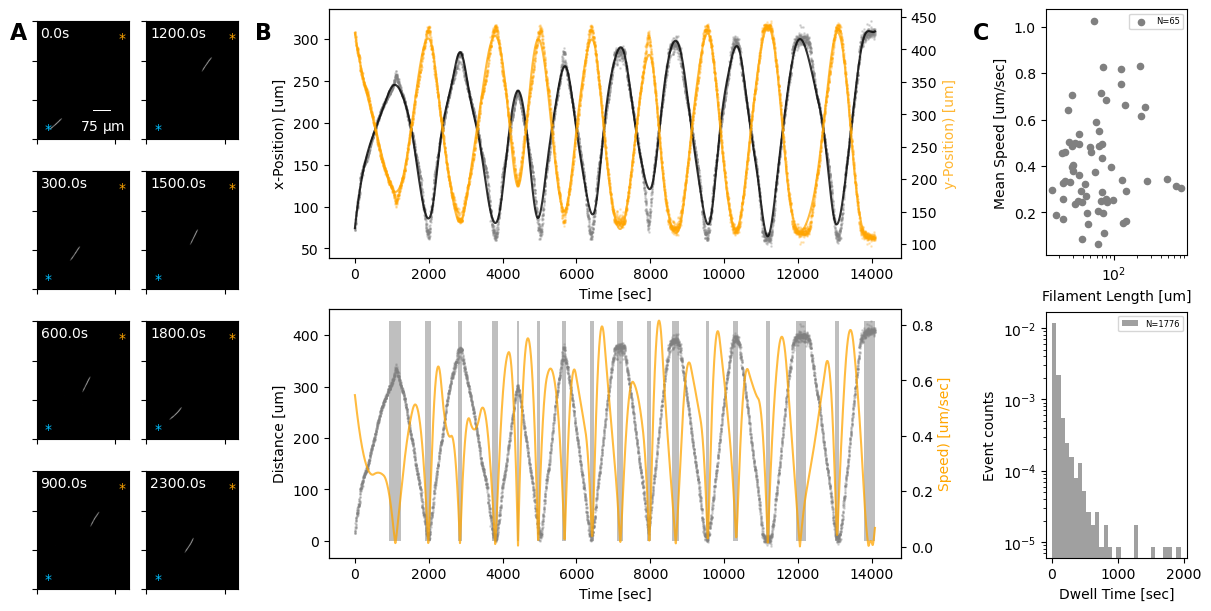

In [12]:
#FANCY PLOT
#OK - let's plot a fancy plot!

fig = plt.figure(layout='constrained', figsize=(12, 6))
#fig = plt.figure(layout='tight', figsize=(12, 6))
#plt.subplots_adjust(left = 0.05, right= 0.95, bottom=0.01, top=0.99,wspace=0.05, hspace=0.05)
#fig = plt.figure(figsize=(12, 6))
#left  = 0.125  # the left side of the subplots of the figure
#right = 0.9    # the right side of the subplots of the figure
#bottom = 0.1   # the bottom of the subplots of the figure
#top = 0.9      # the top of the subplots of the figure
#wspace = 0.2   # the amount of width reserved for blank space between subplots
#hspace = 0.2   # the amount of height reserved for white space between subplots
subfigs = fig.subfigures(1, 3,width_ratios=[1/5,3/5,1/5])

#A - PLOT MOVIE STILLS
axsLeft = subfigs[0].subplots(4, 2, sharex=True,sharey=True)
#figA.subplots_adjust(left = 0.05, right= 0.95, bottom=0.01, top=0.99,wspace=0.02, hspace=0.02)
axsLeft[0,0].text(-0.1, 1, 'A', transform=axsLeft[0,0].transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')

#add scale bar
scalebar = ScaleBar(um_per_px*10**-6,location="lower right",color='w',frameon=False) # 1 pixel = 0.2 meter
axsLeft[0,0].add_artist(scalebar)

tPoints = [0,600,150,750,300,900,450,1150]
k = 0
for i in range(0,4):
      for j in range(0,2):
          axsLeft[i,j].imshow(frames[tPoints[k]],cmap='gray')
          axsLeft[i,j].annotate('*',xy=(trackEndB_x/um_per_px,trackEndB_y/um_per_px),color='deepskyblue')
          axsLeft[i,j].annotate('*',xy=(trackEndA_x/um_per_px,trackEndA_y/um_per_px),color='orange')
          axsLeft[i,j].annotate(str(tPoints[k]*dt)+'s',xy=(10,40),color='white')
          plt.setp(axsLeft[i,j].get_xticklabels(), visible=False)
          plt.setp(axsLeft[i,j].get_yticklabels(), visible=False)
          k=k+1
          

#B - PLOT POSITION, SPEED, ETC.
axsRight = subfigs[1].subplots(2, 1)
axsRight[0].text(-0.1, 0.95, 'B', transform=axsRight[0].transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')
axsRight[0].scatter(frame_ids*dt,centre_x,marker='o',s=1,color='gray',alpha=0.25)  #actual centre x pos
axsRight[0].plot(frame_ids*dt,centre_x_fitted,color='k',alpha=0.8)  #spline for centre x pos
axsRight[0].set_ylabel('x-Position) [um]')
axsRight[0].set_xlabel('Time [sec]')
ax0_2 = axsRight[0].twinx() 
ax0_2.plot(frame_ids*dt,centre_y_fitted,color='orange',alpha=0.75)  #spline for centre y pos
ax0_2.scatter(frame_ids*dt, centre_y,marker='o',s=1,color='orange',alpha=0.2)  #actual centre y pos
ax0_2.set_ylabel('y-Position) [um]',color='orange',alpha=0.8)

#axsRight[1].plot(frame_ids,centre_dist_fitted,color='k')  #spline for centre distance to track end
axsRight[1].scatter(frame_ids*dt, distC,marker='o',s=1,color='gray', alpha=0.25)  #actual centre distance to track end
axsRight[1].set_ylabel('Distance [um]')
axsRight[1].set_xlabel('Time [sec]')
#ax[1].set_xscale('log')
ax1_2 = axsRight[1].twinx() 
ax1_2.plot(frame_ids*dt,np.abs(speedC_xy),color='orange',alpha=0.75)  #spline for centre speed (calculated from centre x-y)
#ax1_2.plot(frame_ids,np.abs(speedC_xy1),color='r')  #spline for centre speed (calculated from centre x-y)
ax1_2.set_ylabel('Speed) [um/sec]',color='orange',alpha=1)
for i in range(0,nReversalsC):
      start = stopIntervalsC[i][0]
      end = stopIntervalsC[i][1]
      width = (end - start)*dt
      if width==0: width=1
      rect = patches.Rectangle((frame_ids[start]*dt,0), width,max(distC), fill=True, alpha=0.5,linewidth=1, edgecolor='none', facecolor='gray')
      axsRight[1].add_patch(rect)
        

#C - PLOT SUMMARY SPEED, ETC.
axsRightRight = subfigs[2].subplots(2, 1)
axsRightRight[0].text(-0.4, 0.95, 'C', transform=axsRightRight[0].transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')
axsRightRight[0].scatter(summaryStats[:,2],summaryStats[:,7],s=20,color='gray',label='N=65')
axsRightRight[0].set_xscale('log')
axsRightRight[0].set_xlabel('Filament Length [um]')
axsRightRight[0].set_ylabel('Mean Speed [um/sec]')
axsRightRight[0].legend(loc="upper right",fontsize=6)

axsRightRight[1].hist(stopDurations[:,0],bins=30, density=True, alpha=0.75, color='gray',label='N=1776',log=True)
axsRightRight[1].set_xlabel('Dwell Time [sec]')
axsRightRight[1].set_ylabel('Event counts')
axsRightRight[1].legend(loc="upper right",fontsize=6)


fig.savefig(saveFile_Fig1)
fig.savefig(saveFile1_Fig1)
#plt.xscale('log')
plt.show()
plt.close(fig)

